# Requirements
First, we import all the packages and modules we need for our pipeline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.grid_search import GridSearchCV

# Suppress scientific notation of float numbers in numpy arrays.
np.set_printoptions(suppress=True)

# Raw Material
Now we retrieve our training and test datasets from the csv files provided by Kaggle and store them in Pandas DataFrame objects.

In [2]:
train = pd.read_csv('data/train.csv')
test_kaggle = pd.read_csv('data/test.csv')


# For running the pipeline with four additional features (LiveabilityScale,
# Income2010, MasterDegree, CommuteTime), use the following two lines
# instead.

# train = pd.read_csv('data/train_extrafeatures.csv')
# test_kaggle = pd.read_csv('data/test_extrafeatures.csv')

print 'train:', train.shape
print 'test:', test_kaggle.shape

train: (1460, 81)
test: (1459, 80)


For later use, we store the feature labels of our training data in two variables, separated by categorical and continious features. Additionally, we store the label of our target variable (SalePrice).

In [3]:
CAT_VARS = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
            'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
            'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
            'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
            'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
            'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
            'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
            'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
            'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
            'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
            'MoSold', 'SaleType', 'SaleCondition']
CONT_VARS = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
             'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
             'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
             'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
             'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
             'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
             'PoolArea', 'MiscVal', 'YrSold',
             
             # For running the pipeline with the additional features, add
             # the following line.
             
             # 'LiveabilityScale', 'Income2010', 'MasterDegree', 'CommuteTime'
             ]

TARGET_VAR = ['SalePrice', ]

# Preprocessing
The house IDs are currently saved in the datasets as ordinary columns. Pandas, however, allows for explicitely specifying indeces, i.e. row labels (much like our feature/column labels). The following makes sure we use our own IDs as indeces.

In [4]:
train.set_index('Id', inplace=True)
test_kaggle.set_index('Id', inplace=True)

The data contains both categorial and continuous values. The following makes sure Pandas knows about this distinction and does not confuse the two by explicetely defining categorial features as such.

In [5]:
for cat_var in CAT_VARS:
    train[cat_var].astype('category')

Some prediction models require continuous features only. Thus, dummify() converts categorial features with *m* different possible classes into *m* new features (columns) – one feature for each class. These dummified features are either 1 or 0. 

For clarification of what's happening, consider the following example:

| Id | Street | → | Street_Gravel | Street_Paved |
|----|--------|---|---------------|--------------|
| 1  | Gravel | → | 1             | 0            |
| 2  | Paved  | → | 0             | 1            |
| 3  |        | → | 0             | 0            |
| 4  | Paved  | → | 0             | 1            |

We apply this dummification both to our training and to our test data. A nice side effect of that is that we do not have to deal with missing categorical values – they are simply set 0 in all the dummy columns (as shown in house 3 of the above example).

In [6]:
def dummify(data, update_cat_vars=False):
    # This allows us to alter the global variable CAT_VARS within the function.
    global CAT_VARS

    # First, we save the data into two new DataFrames – split into categorical
    # and continous features.
    cont_df = data[CONT_VARS]
    cat_df = data[CAT_VARS]
    cat_vars_new = list(CAT_VARS)

    # We iterate over each categorical variable, calculate the dummy variables,
    # insert them into the cat_df DataFrame, and, finally, delete the original
    # (categorical) feature from cat_df.
    # Additionally, we save the labels of our newly created dummy features in
    # CAT_VARS_new.
    for cat_var in CAT_VARS:
        dummies = pd.get_dummies(data[cat_var], prefix=cat_var)
        cat_df = cat_df.join(dummies)
        del cat_df[cat_var]

        cat_vars_new.remove(cat_var)
        cat_vars_new = cat_vars_new + dummies.columns.values.tolist()

    # This merges the continuous and categorical features back into one
    # DataFrame result_df.
    result_df = cat_df.join(cont_df)

    # Up to this point, the SalePrice is missing in our newly created DataFrame
    # result_df. Here we try to insert it again. This might fail because there
    # actually is no target variable in our test set (only in the train set).
    # So, if adding the (potentially missing) SalePrice fails, we just go on
    # without adding it.
    try:
        result_df = result_df.join(data[TARGET_VAR])
    except:
        pass

    # Only update the global CAT_VARS labels if we passed the argument
    # update_cat_vars to the function.
    if (update_cat_vars):
        CAT_VARS = cat_vars_new

    return result_df

# Finally, we dummify both train_df and test_df and print their shape to see
# how the number of columns has increased. When running the function with the
# train data we tell it to update our newly created dummy feature labels in
# the CAT_VARS variable.
test_kaggle = dummify(test_kaggle)
train = dummify(train, update_cat_vars=True)

print 'train:', train.shape
print 'test:', test_kaggle.shape

train: (1460, 311)
test: (1459, 293)


As our columns have changed during dummifying the data, we store the altered list of feature labels in the train data in a new list. As our target variable is not a feature we use for prediction, we exclude it from the list.

In [7]:
VARS_X = list(train.columns)
VARS_X.remove(TARGET_VAR[0])

We dummified our test and train data separately. As not every class (category value) used in the train data is also used in the test data, and vice versa, our columns might no longer match. In order to make sure to realign the number of features (i.e. get the same number of columns), we check for columns which are present in the train data but missing in the test data, add these missing columns to the test data and fill them with zeros (as they apparently aren't present in the test set). Columns present in the test set but not in the train set are entirely dropped from the test set as our model cannot use them for prediction anyway.

In [8]:
cols_missing_in_test = set(VARS_X) - set(test_kaggle.columns)
for col in cols_missing_in_test:
    test_kaggle[col] = 0
    
cols_missing_in_train = set(test_kaggle.columns) - set(VARS_X)
for col in cols_missing_in_train:
    del test_kaggle[col]
    CAT_VARS = list(set(CAT_VARS) - set(cols_missing_in_train))

print 'train:', train.shape
print 'test:', test_kaggle.shape

train: (1460, 311)
test: (1459, 310)


Both the train and the test data have a lot of missing values. The categorical variables are already covered but we still need to fill the gaps of the continuous features. The following fills all missing values by the entire column's mean. Note that the values used to fill the missing test data cells need to be based on the train data's column means.

In [9]:
train = train.fillna(train.mean())
test_kaggle = test_kaggle.fillna(train.mean())

In order to get a sense of how the data looks at this point, we export our train and test data as csv files. After running the next code block, they can be found in the /data/ folder next to this notebook. Note that you might encounter errors if you try to export the files while still having an older version opened.

In [10]:
train.to_csv('data/clean_train.csv', sept=',', index=False)
test_kaggle.to_csv('data/clean_test.csv', sept=',', index=False)

Last not least, we split our train data into two smaller fractions: into a train and a validation set. This allows us two measure the performance of our predictions (without involving the test set which we can only evaluate by uploading it to Kaggle).

In [11]:
# Store all the feature labels of train_df into a list; remove the SalePrice.
features = train.columns.tolist()
features.remove(TARGET_VAR[0])

# Generate the training set. Our train data will contain 80% of train_df.
train_frac = train.sample(frac=0.8)

# Select anything not in the training set (20%) and put it in the validation
# set.
validation = train.loc[~train.index.isin(train_frac.index)]

print "train (80%):"
print train.shape
print "validation (20%):"
print validation.shape

train (80%):
(1460, 311)
validation (20%):
(292, 311)


Here we create an empty DataFrame where we fill in all the predictions on our train dataset for later use when we tune our final mixed model.

In [12]:
mixed_model_predictions_train = pd.DataFrame()

# Linear Regression
Now we're finally ready two use our preprocessed data for training a linear regression model based on the 80% train set.

In [13]:
# Initialize the model class.
linear_regression_model = LinearRegression()

# Fit the model to the 80% training data.
linear_regression_model.fit(train_frac[features], train_frac[TARGET_VAR[0]])

# Generate our predictions for the validation set.
predictions = linear_regression_model.predict(validation[features])

# Compute error between our validation predictions and the actual values.
print 'Mean Sqared Error:', mean_squared_error(predictions,
                                               validation[TARGET_VAR[0]])

Mean Sqared Error: 1098700416.14


Next, we print a learning curve to examine if our model suffers from overfitting or underfitting. The functions will be reusable for our other models as well.

In [14]:
def learning_curve(X_train, y_train, X_test, y_test, model, scale):
    # Vary the training set size so that we have 25 different sizes
    sizes = np.round(np.linspace(1, len(X_train), 25))
    
    # Create empty arrays which we can fill with the error rates.
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))
    
    # Shuffle the training examples' order.
    X_train = X_train.sample(frac=1)
    
    # Iterate over all the training set sizes.
    for i, s in enumerate(sizes):
        # Fit the model to the train set.
        model.fit(X_train[:int(s)], y_train[:int(s)])
   
        # Evaluate the model's performance on the train and test set.
        train_err[i] = mean_squared_error(y_train[:int(s)],
                                          model.predict(X_train[:int(s)]))
        test_err[i] = mean_squared_error(y_test,
                                         model.predict(X_test))
        
    # Plot the learning curve.
    learning_curve_graph(sizes, train_err, test_err, scale)

def learning_curve_graph(sizes, train_err, test_err, scale):
    # Initialize the graph.
    plt.figure()
    
    # Add a headline.
    plt.title('Learning Curve')
    
    # Label the two curves, add a legend, label the axes.
    plt.plot(sizes, test_err, label='test error')
    plt.plot(sizes, train_err, label='training error')
    plt.legend()
    plt.xlabel('Training Size')
    plt.ylabel('Error')
    
    # Set the scale of the graph.
    plt.ylim(scale)
    
    # Plot the graph.
    plt.show()    

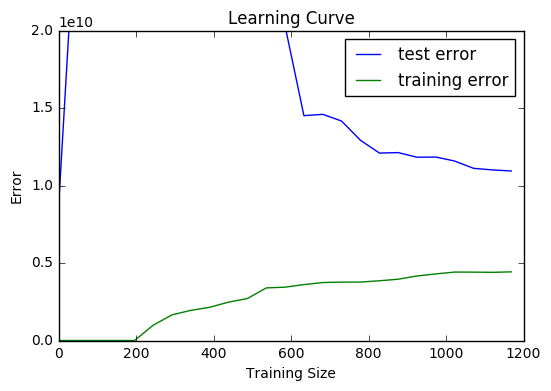

In [15]:
# Plot the learning curve. The scale argument might require some tweaking
# as the learning curve depends on some degree of randomness.
learning_curve(train_frac[features],
               train_frac[TARGET_VAR[0]],
               validation[features],
               validation[TARGET_VAR[0]],
               LinearRegression(),
               [0, 20000000000])

Now we can improve our model by using the entire 100% of our train set.

In [16]:
linear_regression_model = LinearRegression() #(normalize=True)?
linear_regression_model.fit(train[features], train[TARGET_VAR[0]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now we can use this improved model to predict the housing prices of Kaggle's external test data.

In [17]:
predictions = linear_regression_model.predict(test_kaggle[features])
predictions.shape

(1459L,)

Due to a lack of a validation set, we are now no longer able to compute the mean squared error. But by uploading our predictions for the test set to Kaggle, we can get an even better sense of how good we're doing in terms of generalisability. This requires preparing a csv file according to Kaggle's requirements: one column with the ID, and one column with the predicted SalePrice. We create a function we can also reuse for other models.

In [18]:
def export_csv(predictions, model):
    # Get the IDs from the indeces we earlier stored in the test set.
    ids = test_kaggle.index.values

    # Stack the IDs and predictions into a numpy array and transpose it into
    # vertical form.
    submission = np.vstack((ids, predictions)).T

    # Convert the submission array into a Pandas DataFrame object.
    submission = pd.DataFrame(data=submission, columns=['Id', 'SalePrice'])

    # Convert Id from float to int to avoid .0 notation.
    submission['Id'] = submission['Id'].astype(int)
    
    # Kaggle does not accept negative prediction values. As a linear model might
    # potentially produce some, we convert them to 0.
    submission[submission < 0] = 0

    # Print the shape of the newly created submission DataFrame.
    print 'Submission:', submission.shape
    
    # Export the submissions to a csv file.
    submission.to_csv('submissions/submission_' + model + '.csv', sept=',', index=False)

Now we can call the export_csv function to print our Linear Regression predictions to a csv file called submission_linear_regression.csv.

In [19]:
export_csv(predictions, 'linear_regression')

Submission: (1459, 2)


# Ridge Regression
Ridge regression is a linear regression model with regularization. The alpha value which determines the degree to which high weights are penalized in order to simplify the function and to avoid overfitting needs to be optimized.

In [20]:
# This list contains all the different values we want to test as
# our hyperparameter alpha.
alphas = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12,
          10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 60,
          70, 80, 90, 100]

# Train a new Ridge regression model on the 100% train data while
# trying different values for alpha using cross-validation.
ridge_regression_model = RidgeCV(alphas=alphas)
ridge_regression_model.fit(train[features], train[TARGET_VAR[0]])

# Save optimal value for alpha in a variable for later use.
alpha = ridge_regression_model.alpha_
print 'alpha:', alpha

alpha: 11.0


In order to evaluate our model with the optimized alpha value, we print a learning curve which indicates if our model suffers from overfitting.

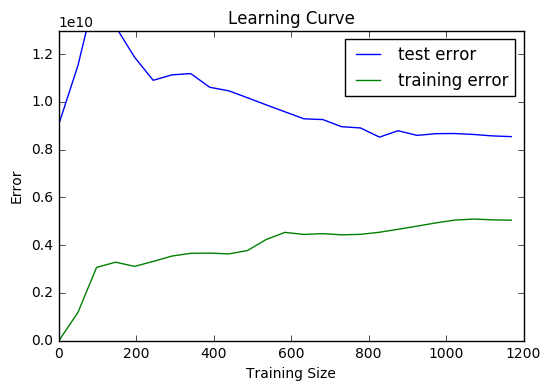

In [21]:
# Plot the learning curve. The scale argument might require some tweaking
# as the learning curve depends on some degree of randomness.
learning_curve(train_frac[features],
               train_frac[TARGET_VAR[0]],
               validation[features],
               validation[TARGET_VAR[0]],
               Ridge(alpha=alpha),
               [0, 13000000000])

If everything looks good, we can save our predictions to a csv file for submission to Kaggle.

In [22]:
predictions = ridge_regression_model.predict(test_kaggle[features])
export_csv(predictions, 'ridge_regression')

Submission: (1459, 2)


# Lasso Regression
The Ridge regression already performed better than the linear regression. However, we try yet another algorithm, the Lasso regression, which effectively favors a smaller number of the most relevant features by penalizing weights accordingly.

In [23]:
# Again, this list contains all the different values we want to test
# as our hyperparameter alpha.
alphas = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200,
          210, 220, 230, 240, 250, 260, 270]

# Train a new Lasso regression model on the 100% train data while
# trying different values for alpha using cross-validation.
lasso_regression_model = LassoCV(alphas=alphas)
lasso_regression_model.fit(train[features], train[TARGET_VAR[0]])

# Save optimal value for alpha in a variable for later use.
alpha = lasso_regression_model.alpha_
print 'alpha:', alpha

alpha: 140


C:\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


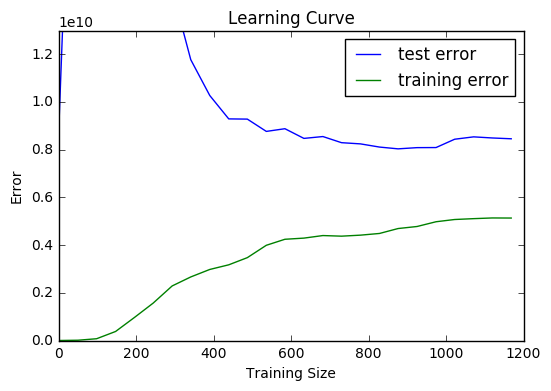

In [24]:
# Plot the learning curve. The scale argument might require some tweaking
# as the learning curve depends on some degree of randomness.
learning_curve(train_frac[features],
               train_frac[TARGET_VAR[0]],
               validation[features],
               validation[TARGET_VAR[0]],
               Lasso(alpha=alpha),
               [0, 13000000000])

In [25]:
# Use the optimized Lasso regression model to predict the house prices
# of Kaggle's test set.
predictions = lasso_regression_model.predict(test_kaggle[features])

# Export the predictions to a csv file.
export_csv(predictions, 'lasso_regression')

# Print the model's configuration.
print lasso_regression_model

Submission: (1459, 2)
LassoCV(alphas=[100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270],
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)


In [26]:
# Use the trained lasso model to predict the prices of the train set for
# later use in a mixed model experiment.
mixed_model_predictions_train["lasso"] = lasso_regression_model.predict(train[features])

# Random Forest Regressor
Next, we try a nonlinear method: Random Forest Regressor. In the following code block we optimize a few hyperparameters with a grid search in order to find the best configuration. As a grid search is highly expensive, the grid's hyperparameter values below were narrowed down gradually and only represent a small subset of all the values that have been tested. This also applies to the grid searches performed on all the other models below.

In [27]:
# We set n_estimators to a fixed value upfront. There's no point in
# optimnizing it because it just represents a trade-off between
# prediction quality and computational cost: The higher the value
# the better the prediction but also the slower the computation.
n_estimators = 25

# We set n_jobs to -1 so that the number of used processors is not
# limited.
n_jobs = -1

# Initialize the random forest model.
random_forest_model = RandomForestRegressor(n_estimators=n_estimators,
                                            n_jobs=n_jobs)

# This grid contains all the different values we want to test with
# our hyperparameters. The larger the grid, the longer the optimization
# takes because all possible combinations are tested.
param_grid = {"max_depth": [12, 13, 14, 15, 16],
              "max_features": [.1, .11, .12, .13],
              "min_samples_split": [1, 2, 3, 4],
              "min_samples_leaf": [1, 2],
              "bootstrap": [False, True]}

# Initialize the grid search with our random forest model and our
# parameter grid.
grid_search = GridSearchCV(estimator=random_forest_model,
                           param_grid=param_grid)

# Fit grid search to the training data.
grid_search.fit(train[features], train[TARGET_VAR[0]])

# Save the optimal values for the hyperparameters in new variables
# for later use.
max_depth = grid_search.best_estimator_.max_depth
max_features = grid_search.best_estimator_.max_features
min_samples_split = grid_search.best_estimator_.min_samples_split
min_samples_leaf = grid_search.best_estimator_.min_samples_leaf
bootstrap = grid_search.best_estimator_.bootstrap

# Show optimized values for our hyperparameters.
print 'max_depth:', max_depth
print 'max_features:', max_features
print 'min_samples_split:', min_samples_split
print 'min_samples_leaf:', min_samples_leaf
print 'bootstrap:', bootstrap

max_depth: 15
max_features: 0.11
min_samples_split: 2
min_samples_leaf: 1
bootstrap: False


Now we can fit the model to our 100% train dataset, predict the values for Kaggle's test dataset, and export the results into a csv file.

In [28]:
# To improve the prediction quality, we increase the number of
# trees in our random forest. In case of limited processing
# capacity, decrease this number.
n_estimators = 200

# Initialize the model with the optimized hyperparameters.
random_forest_model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_features=max_features,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    bootstrap=bootstrap,
    n_jobs=n_jobs
)

# Fit model to 100% train set.
random_forest_model.fit(train[features], train[TARGET_VAR[0]])

# Print model configuration.
print random_forest_model

# Predict housing prices of Kaggle's test set.
predictions = random_forest_model.predict(test_kaggle[features])

# Export predictions to a csv file.
export_csv(predictions, 'random_forest_regressor')

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=15,
           max_features=0.11, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Submission: (1459, 2)


In [29]:
# Use the trained random forest to predict the prices of the train set for
# later use in a mixed model experiment.

mixed_model_predictions_train["random_forest"] = random_forest_model.predict(train[features])

# AdaBoost

AdaBoost combines multiple iterations of a weak learner, weights the results, and ultimately outputs reasonable predictions. We use shallow decision trees as weak learners. In the following codeblock, we optimize the hyperparameters.

In [30]:
# We set n_jobs to -1 so that the number of used processors is not
# limited.
n_jobs = -1

# Initialize our weak learner, a random forest regressor.
decision_tree_model = DecisionTreeRegressor()

# Initialize AdaBoost model with random forest as weak learner.
adaboost_model = AdaBoostRegressor(base_estimator=decision_tree_model)

# This grid contains all the different values we want to test with
# our hyperparameters. The larger the grid, the longer the optimization
# takes because all possible combinations are tested.
param_grid = {"n_estimators": [106, 107, 108],
              "base_estimator__max_depth": [21, 22, 23, 24, 25],
              "base_estimator__max_features": [.37, .38, .39, .4, .41],
              "base_estimator__min_samples_split": [1, 2, 3],
              "base_estimator__min_samples_leaf": [1, 2, 3]}

# Initialize the grid search with our AdaBoost model and our
# parameter grid.
grid_search = GridSearchCV(estimator=adaboost_model,
                           param_grid=param_grid)

# Fit grid search to the training data.
grid_search.fit(train[features], train[TARGET_VAR[0]])

# Save the optimal values for the hyperparameters in new variables
# for later use.
n_estimators = grid_search.best_estimator_.n_estimators
base_estimator__max_depth = grid_search.best_estimator_.base_estimator.max_depth
base_estimator__max_features = grid_search.best_estimator_.base_estimator.max_features
base_estimator__min_samples_split = grid_search.best_estimator_.base_estimator.min_samples_split
base_estimator__min_samples_leaf = grid_search.best_estimator_.base_estimator.min_samples_leaf

# Show optimized values for our hyperparameters.
print 'n_estimators:', n_estimators
print 'base_estimator__max_depth:', base_estimator__max_depth
print 'base_estimator__max_features:', base_estimator__max_features
print 'base_estimator__min_samples_split:', base_estimator__min_samples_split
print 'base_estimator__min_samples_leaf:', base_estimator__min_samples_leaf

n_estimators: 108
base_estimator__max_depth: 25
base_estimator__max_features: 0.39
base_estimator__min_samples_split: 3
base_estimator__min_samples_leaf: 2


Finally, we run another AdaBoost regressor with the optimized hyperparameters on the Kaggle test dataset and export our predictions into a csv file.

In [31]:
# Initialize weak learner with optimized hyperparameters.
decision_tree_model = DecisionTreeRegressor(
    max_depth=base_estimator__max_depth,
    max_features=base_estimator__max_features,
    min_samples_split=base_estimator__min_samples_split,
    min_samples_leaf=base_estimator__min_samples_leaf
)

# Initialize AdaBoost.
adaboost_model = AdaBoostRegressor(
    base_estimator=decision_tree_model,
    n_estimators=n_estimators
)

# Train model on 100% train data.
adaboost_model.fit(train[features], train[TARGET_VAR[0]])

# Predict the house prices for Kaggle's test data.
predictions = adaboost_model.predict(test_kaggle[features])

# Export predictions to a csv file.
export_csv(predictions, 'adaboost')

# Print the model's configuration.
print adaboost_model

Submission: (1459, 2)
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=25, max_features=0.39,
           max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=3,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=108,
         random_state=None)


In [32]:
# Use the trained AdaBoost model to predict the prices of the train set for
# later use in a mixed model experiment.

mixed_model_predictions_train["adaboost"] = adaboost_model.predict(train[features])

# Mixed Model: Average
Now we take the average of all our comparably good models to make a prediction which is, hopefully, even better as it balances out the different biases.

In [33]:
# Store predictions of the different models in DataFrame objects.
lasso = pd.read_csv('submissions/submission_lasso_regression.csv')
random_forest = pd.read_csv('submissions/submission_random_forest_regressor.csv')
adaboost = pd.read_csv('submissions/submission_adaboost.csv')

# Set column indices.
lasso.set_index('Id', inplace=True)
random_forest.set_index('Id', inplace=True)
adaboost.set_index('Id', inplace=True)

# Rename columns.
lasso.columns = ['lasso']
random_forest.columns = ['random_forest']
adaboost.columns = ['adaboost']

# Merge model predictions into one DataFrame object.
mixed_model_predictions_test = pd.concat([adaboost, lasso, random_forest], axis=1)

# Calculate mean values of the models' predictions.
predictions = mixed_model_predictions_test.mean(axis=1).as_matrix()

# Export mean predictions to a csv submission file.
export_csv(predictions, 'mixed_mean')

Submission: (1459, 2)


# Mixed Model: Linear Regression
The mixed model above simply used the average of our different models' predictions. However, this does not take into account the different biases of our models. Consequently, we now calculate a linear regression with the different model predictions for our training examples as features and the actual SalePrices as target variable. This way, we can calculate weights which we can use to control the weighted influence of each model's predictions on the final predictions of the mixed model.

In [34]:
# Add the actual SalePrice of the train data to the DataFrame
# containing the train data predictions of our various models.
mixed_model_predictions_train['SalePrice'] = train[TARGET_VAR].as_matrix()

# Run a linear regression to determine weights for our different
# model predictions.
linear_regression_model = LinearRegression()
linear_regression_model.fit(
    mixed_model_predictions_train[["lasso", "random_forest", "adaboost"]],
    mixed_model_predictions_train[TARGET_VAR[0]]
)

# Predict the mixed model SalePrices based on the weighted models.
predictions = linear_regression_model.predict(mixed_model_predictions_test)

# Export to csv.
export_csv(predictions, 'mixed_regression')

Submission: (1459, 2)


# Mixed Model: Random Forest

The mixed model with linear regression worked great. Doing the same with a more advanced regressor – random forest – might improve the results even further.

In [35]:
# We set n_estimators to a fixed value upfront.
n_estimators = 25

# We set n_jobs to -1 so that the number of used processors is not
# limited.
n_jobs = -1

# We set random_state to an arbitrary fixed value to make sure the
# results during testing are comparable.
random_state = 42

# Initialize the random forest model.
random_forest_model = RandomForestRegressor(n_estimators=n_estimators,
                                            random_state=random_state,
                                            n_jobs=n_jobs)

# This grid contains all the different values we want to test with
# our hyperparameters. The larger the grid, the longer the optimization
# takes because all possible combinations are tested.
param_grid = {"max_depth": [15, 16, 17, 18, 19, 20],
              "max_features": [1, 2, 3],
              "min_samples_split": [1, 2, 3],
              "min_samples_leaf": [1, 2, 3],
              "bootstrap": [False, True]}

# Initialize the grid search with our random forest model and our
# parameter grid.
grid_search = GridSearchCV(estimator=random_forest_model,
                           param_grid=param_grid)

# Fit grid search to the model predictions.
grid_search.fit(
    mixed_model_predictions_train[["lasso", "random_forest", "adaboost"]],
    mixed_model_predictions_train[TARGET_VAR[0]]
)

# Save the optimal values for the hyperparameters in new variables
# for later use.
max_depth = grid_search.best_estimator_.max_depth
max_features = grid_search.best_estimator_.max_features
min_samples_split = grid_search.best_estimator_.min_samples_split
min_samples_leaf = grid_search.best_estimator_.min_samples_leaf
bootstrap = grid_search.best_estimator_.bootstrap

# Show optimized values for our hyperparameters.
print 'max_depth:', max_depth
print 'max_features:', max_features
print 'min_samples_split:', min_samples_split
print 'min_samples_leaf:', min_samples_leaf
print 'bootstrap:', bootstrap

max_depth: 16
max_features: 2
min_samples_split: 1
min_samples_leaf: 1
bootstrap: False


Now we can fit the model to our model predictions again, predict the final mixed SalePrices for Kaggle's test dataset, and export the results into a csv file.

In [36]:
random_forest_model = RandomForestRegressor(
    random_state=random_state,
    n_estimators=n_estimators,
    max_features=max_features,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    bootstrap=bootstrap,
    n_jobs=n_jobs
)

random_forest_model.fit(
    mixed_model_predictions_train[["lasso", "random_forest", "adaboost"]],
    mixed_model_predictions_train[TARGET_VAR[0]]
)
predictions = random_forest_model.predict(mixed_model_predictions_test)
export_csv(predictions, 'mixed_random_forest')

Submission: (1459, 2)


Turns out: This didn't help improving the evaluation score on Kaggle's external test set compared to the mixed model with linear regression. An explanation might be that the nonlinear random forest actually favors the models which suffer from overfitting as these models tend to describe the training set better.